<a href="https://colab.research.google.com/github/phfcs/CienciadeDados.2/blob/main/notebook_Projeto2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [107]:
!pip install --quiet optuna
!pip install mlflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [108]:
%matplotlib inline
import pandas as pd
import statsmodels.api as sm
import itertools
import matplotlib.pyplot as plt
from prophet import Prophet
import optuna
import mlflow
from statsmodels.tsa.ar_model import AutoReg

In [109]:
data = pd.read_csv('./2004-2021.csv')

In [110]:
data.dtypes

DATA INICIAL                      object
DATA FINAL                        object
REGIÃO                            object
ESTADO                            object
PRODUTO                           object
NÚMERO DE POSTOS PESQUISADOS       int64
UNIDADE DE MEDIDA                 object
PREÇO MÉDIO REVENDA              float64
DESVIO PADRÃO REVENDA            float64
PREÇO MÍNIMO REVENDA             float64
PREÇO MÁXIMO REVENDA             float64
MARGEM MÉDIA REVENDA              object
COEF DE VARIAÇÃO REVENDA         float64
PREÇO MÉDIO DISTRIBUIÇÃO          object
DESVIO PADRÃO DISTRIBUIÇÃO        object
PREÇO MÍNIMO DISTRIBUIÇÃO         object
PREÇO MÁXIMO DISTRIBUIÇÃO         object
COEF DE VARIAÇÃO DISTRIBUIÇÃO     object
dtype: object

In [111]:
data['DATA INICIAL'] = pd.to_datetime(data['DATA INICIAL'])
data['DATA FINAL'] = pd.to_datetime(data['DATA FINAL'])

In [112]:
for colname in ['REGIÃO', 'ESTADO', 'PRODUTO']:
    data[colname] = data[colname].astype('category')

data[['REGIÃO', 'ESTADO', 'PRODUTO']].dtypes

REGIÃO     category
ESTADO     category
PRODUTO    category
dtype: object

Os dados lidos apresentam vários estados e produtos, implicando diferentes previsões para cada. Nos atendo aos propósitos deste projeto, preveremos somente para Pernambuco e o produto mais comum.

In [113]:
data['ESTADO'].unique()

['DISTRITO FEDERAL', 'GOIAS', 'MATO GROSSO', 'MATO GROSSO DO SUL', 'ALAGOAS', ..., 'RIO DE JANEIRO', 'SAO PAULO', 'PARANA', 'RIO GRANDE DO SUL', 'SANTA CATARINA']
Length: 27
Categories (27, object): ['ACRE', 'ALAGOAS', 'AMAPA', 'AMAZONAS', ..., 'SANTA CATARINA',
                          'SAO PAULO', 'SERGIPE', 'TOCANTINS']

In [114]:
data_pern = data[data['ESTADO'] == 'PERNAMBUCO']
len(data_pern)

4813

In [115]:
for p in data_pern['PRODUTO'].unique():
    print(f'Quantidade de {p}: {(data_pern["PRODUTO"] == p).sum()}')

Quantidade de ETANOL HIDRATADO: 872
Quantidade de GASOLINA COMUM: 873
Quantidade de GLP: 873
Quantidade de GNV: 873
Quantidade de ÓLEO DIESEL: 785
Quantidade de ÓLEO DIESEL S10: 338
Quantidade de OLEO DIESEL: 83
Quantidade de OLEO DIESEL S10: 88
Quantidade de GASOLINA ADITIVADA: 28


In [116]:
data_pern = data_pern[data_pern['PRODUTO'] == 'ETANOL HIDRATADO']

In [117]:
data_pern.index = data_pern['DATA INICIAL']

Preveremos o preço médio de revenda, utilizando ARIMA inicialmente

In [118]:
data_pern.index.max()

Timestamp('2021-04-25 00:00:00')

Dado que temos informações desde 2004 até abril de 2021, podemos dividir os dados em treinamento até o final do primeiro semestre de 2020, validação desse ponto até o final do segundo semestre de 2020, e teste o que resta. Vamos também obter os dados médios por mês, para poder usar 12 como parâmetro de sazonalidade do SARIMAX.

In [119]:
data_pern = data_pern.resample('m').mean()

In [120]:
data_pern_train = data_pern[:'2020-06']
data_pern_validation = data_pern['2020-07':'2020-12']
data_pern_test = data_pern['2021-01':'2021-04']

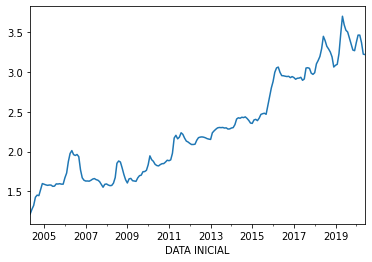

In [121]:
data_pern_train['PREÇO MÉDIO REVENDA'].plot()

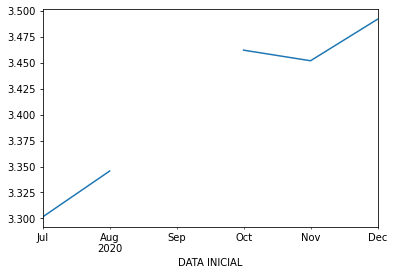

In [122]:
data_pern_validation['PREÇO MÉDIO REVENDA'].plot()

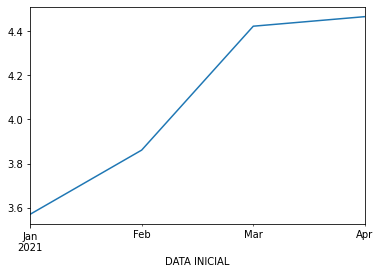

In [123]:
data_pern_test['PREÇO MÉDIO REVENDA'].plot()

Vamos agora realizar uma grid-search para determinar os melhores parâmetros para o algoritmo

In [124]:
y = data_pern_train['PREÇO MÉDIO REVENDA']

In [125]:
def objective(trial):
    p = trial.suggest_int('p', 0, 2)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 2)

    ps = trial.suggest_int('ps', 0, 2)
    ds = trial.suggest_int('ds', 0, 2)
    qs = trial.suggest_int('qs', 0, 0)

    mdl = sm.tsa.statespace.SARIMAX(
        y,
        order=(p, d, q),
        seasonal_order=(ps, ds, qs, 12),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    results = mdl.fit()

    trial.report(results.aic, 0)

    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return results.aic

In [126]:
def print_study_best_trial_params(study):
    t = study.best_trial

    print(f'Melhor valor: {t.value}')

    print(f'Melhores parâmetros:')

    for p, v in t.params.items():
        print(f'{p}: {v}')

In [127]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300)

print_study_best_trial_params(study)

[I 2022-09-15 18:56:31,707] A new study created in memory with name: no-name-4112f8e6-f133-4694-b1c2-406e962d8537
[I 2022-09-15 18:56:35,110] Trial 0 finished with value: -291.0175340022297 and parameters: {'p': 2, 'd': 2, 'q': 2, 'ps': 1, 'ds': 2, 'qs': 0}. Best is trial 0 with value: -291.0175340022297.
[I 2022-09-15 18:56:36,299] Trial 1 finished with value: -429.3501184265924 and parameters: {'p': 2, 'd': 1, 'q': 2, 'ps': 0, 'ds': 1, 'qs': 0}. Best is trial 1 with value: -429.3501184265924.
[I 2022-09-15 18:56:38,435] Trial 2 finished with value: -474.3876429264782 and parameters: {'p': 2, 'd': 0, 'q': 2, 'ps': 1, 'ds': 1, 'qs': 0}. Best is trial 2 with value: -474.3876429264782.
[I 2022-09-15 18:56:38,918] Trial 3 finished with value: -417.3539829311775 and parameters: {'p': 2, 'd': 1, 'q': 1, 'ps': 0, 'ds': 1, 'qs': 0}. Best is trial 2 with value: -474.3876429264782.
[I 2022-09-15 18:56:42,271] Trial 4 finished with value: -449.00230754550876 and parameters: {'p': 2, 'd': 0, 'q':

Melhor valor: -602.8506333609209
Melhores parâmetros:
p: 2
d: 0
q: 1
ps: 0
ds: 0
qs: 0


Determinados os melhores parâmetros, vamos treinar o nosso modelo e realizar uma previsão

In [128]:
pdq = (2, 0, 1)
pdqs = (0, 0, 0, 12)

mod = sm.tsa.statespace.SARIMAX(
    y,
    order=pdq,
    seasonal_order=pdqs,
    enforce_stationarity=False,
    enforce_invertibility=False
)

res = mod.fit()

In [129]:
mlflow.log_params({ "sarimax_pdq": pdq, "sarimax_pdqs": pdqs })
mlflow.statsmodels.log_model(res, "sarimax")

ModelInfo(artifact_path='sarimax', flavors={'python_function': {'loader_module': 'mlflow.statsmodels', 'python_version': '3.7.14', 'data': 'model.statsmodels', 'env': 'conda.yaml'}, 'statsmodels': {'statsmodels_version': '0.12.2', 'data': 'model.statsmodels', 'code': None}}, model_uri='runs:/ca633405d54e482cbc7d23084592682a/sarimax', model_uuid='a1d4a844b7d3468ba0eeab14f1323ad8', run_id='ca633405d54e482cbc7d23084592682a', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-09-15 18:58:01.149023', mlflow_version='1.28.0')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


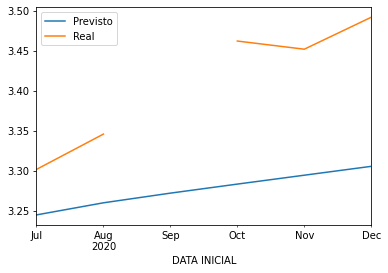

In [130]:
predicted = res.get_prediction(start='2020-07', end='2020-12')
predicted.predicted_mean.plot(label='Previsto')
data_pern_validation['PREÇO MÉDIO REVENDA'].plot(label='Real')
plt.legend()

Repitamos a previsão para o intervalo de tempo de teste

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


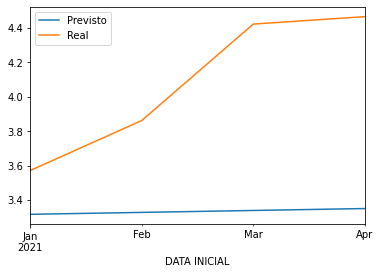

In [131]:
predicted_test = res.get_prediction(start = '2021-01', end='2021-04')
predicted_test.predicted_mean.plot(label='Previsto')
data_pern_test['PREÇO MÉDIO REVENDA'].plot(label='Real')
plt.legend()

MSE (Mean Squared Error):

In [132]:
sarimax_mse = ((predicted_test.predicted_mean - data_pern_test['PREÇO MÉDIO REVENDA']) ** 2).mean()
sarimax_mse

0.6915642562430931

In [133]:
mlflow.log_metric('sarimax_mse', sarimax_mse)

### Prophet

In [134]:
prophet_df = pd.DataFrame()
prophet_df['y'] = data_pern_train['PREÇO MÉDIO REVENDA']
prophet_df['ds'] = data_pern_train.index

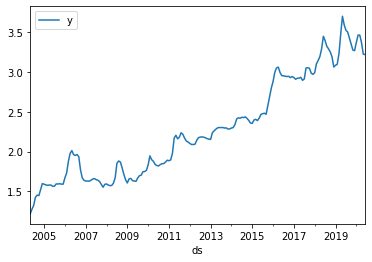

In [135]:
prophet_df.plot(x='ds')

In [138]:
def prophet_objective(trial):
    changepoint_prior_scale = trial.suggest_float('changepoint_prior_scale', .001, .5)
    seasonality_prior_scale = trial.suggest_float('seasonality_prior_scale', .01, 10)
    holidays_prior_scale = trial.suggest_float('holidays_prior_scale', .01, 10)

    prophet = Prophet(
        changepoint_prior_scale=changepoint_prior_scale,
        seasonality_prior_scale=seasonality_prior_scale,
        holidays_prior_scale=holidays_prior_scale
    )

    prophet.fit(prophet_df)

    future_df = prophet.make_future_dataframe(periods=6, freq='m')
    future_pred = prophet.predict(future_df)

    mse = ((future_pred[-6:]['yhat'].reset_index(drop=True) - data_pern_validation['PREÇO MÉDIO REVENDA'].reset_index(drop=True)) ** 2).mean()

    trial.report(mse, 0)

    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return mse

In [139]:
prophet_study = optuna.create_study(direction="minimize")
prophet_study.optimize(prophet_objective, n_trials=80)

print_study_best_trial_params(prophet_study)

[I 2022-09-15 18:59:01,647] A new study created in memory with name: no-name-89eab022-05ee-4f5a-a13f-9087bf53b2ce
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp903hhn6f/lw2zpyq8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp903hhn6f/c0rezbs5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55500', 'data', 'file=/tmp/tmp903hhn6f/lw2zpyq8.json', 'init=/tmp/tmp903hhn6f/c0rezbs5.json', 'output', 'file=/tmp/tmp2ix7s8oo/prophet_model-20220915185901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
18:59:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
18:59:02 - cmdstanpy - INFO - Chain [1] done p

Melhor valor: 0.015965459593386515
Melhores parâmetros:
changepoint_prior_scale: 0.2663275253103461
seasonality_prior_scale: 0.013453692749858285
holidays_prior_scale: 6.09254240862366


In [140]:
prophet = Prophet(**prophet_study.best_trial.params)
prophet.fit(prophet_df)
future_df = prophet.make_future_dataframe(periods=6, freq='m')
future_pred = prophet.predict(future_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp903hhn6f/jv67ozwu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp903hhn6f/r0freymh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=32440', 'data', 'file=/tmp/tmp903hhn6f/jv67ozwu.json', 'init=/tmp/tmp903hhn6f/r0freymh.json', 'output', 'file=/tmp/tmpj9t1mmh8/prophet_model-20220915190224.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:02:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:02:24 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [147]:
last_6_months = future_pred[-4:].reset_index(drop=True)
last_6_months.index = data_pern_test.index

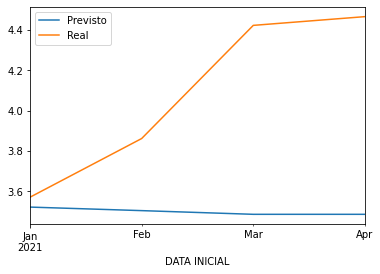

In [148]:
last_6_months['yhat'].plot(label='Previsto')
data_pern_test['PREÇO MÉDIO REVENDA'].plot(label='Real')
plt.legend()

In [145]:
prophet_mse = ((future_pred[-6:]['yhat'].reset_index(drop=True) - data_pern_test['PREÇO MÉDIO REVENDA'].reset_index(drop=True)) ** 2).mean()
prophet_mse

0.4622559604531198

In [146]:
for name, value in prophet_study.best_trial.params.items():
    mlflow.log_param(f'fbprophet_{name}', value)
mlflow.sklearn.log_model(prophet, 'prophet')
mlflow.log_metric('prophet_mse', prophet_mse)

**Auto Regression**

In [150]:
ar_y = data_pern_train['PREÇO MÉDIO REVENDA']

In [151]:
from statsmodels.tsa.ar_model import AutoReg

def ar_objective(trial):
    mdl = AutoReg(ar_y, lags=trial.suggest_int('lags', 0, 6))
    
    res = mdl.fit()
    
    aic = res.aic
    
    trial.report(aic, 0)
    
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
        
    return aic

In [152]:
ar_study = optuna.create_study(direction="minimize")
ar_study.optimize(ar_objective, n_trials=10)

print_study_best_trial_params(ar_study)

[I 2022-09-15 19:09:31,211] A new study created in memory with name: no-name-3c971232-9141-470e-b24f-0faae9e4eccb
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/ar_model.py:252: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)
[I 2022-09-15 19:09:31,253] Trial 0 finished with value: -0.9181705624457421 and parameters: {'lags': 0}. Best is trial 0 with value: -0.9181705624457421.
[I 2022-09-15 19:09:31,275] Trial 1 finished with value: -5.939544564248669 and parameters: {'lags': 2}. Best is trial 1 with value: -5.939544564248669.
[I 2022-09-15 19:09:31,295] Trial 2 finished with value: -5.939544564248669 and parameters: {

Melhor valor: -5.987866945207642
Melhores parâmetros:
lags: 3


In [153]:
ar_mdl = AutoReg(ar_y, **ar_study.best_trial.params)
ar_res = ar_mdl.fit()

In [154]:
mlflow.log_param('ar_lags', ar_study.best_trial.params['lags'])
mlflow.statsmodels.log_model(ar_res, 'autoregression')

ModelInfo(artifact_path='autoregression', flavors={'python_function': {'loader_module': 'mlflow.statsmodels', 'python_version': '3.7.14', 'data': 'model.statsmodels', 'env': 'conda.yaml'}, 'statsmodels': {'statsmodels_version': '0.12.2', 'data': 'model.statsmodels', 'code': None}}, model_uri='runs:/ca633405d54e482cbc7d23084592682a/autoregression', model_uuid='fa57263c03614caeb660c50e8f7466fd', run_id='ca633405d54e482cbc7d23084592682a', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-09-15 19:09:36.192998', mlflow_version='1.28.0')

Os parâmetros de previsão para o modelo de autoregressão são os índices de início e fim da previsão. Como desejamos prever 6 meses, devemos fornecer o índice do último item mais um, que é o mesmo que o tamanho de ar_y, e o índice do sexto mês a partir do fim

In [167]:
prediction = ar_res.predict(start=len(ar_y), end=len(ar_y) + 5)
prediction

2020-07-31    3.253060
2020-08-31    3.278056
2020-09-30    3.286371
2020-10-31    3.286763
2020-11-30    3.286438
2020-12-31    3.287684
Freq: M, dtype: float64

In [206]:
index = data_pern_test.index

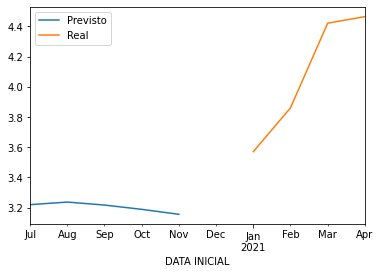

In [205]:
prediction.plot(label='Previsto')
data_pern_test['PREÇO MÉDIO REVENDA'].plot(label='Real')
plt.legend()

In [181]:
ar_mse = ((data_pern_test['PREÇO MÉDIO REVENDA'] + prediction) ** 2).mean()
ar_mse

nan

In [176]:
mlflow.log_metric('ar_mse', ar_mse)

### Holt Winter's Exponential Smoothing

In [162]:
hwes_y = data_pern_train['PREÇO MÉDIO REVENDA']

In [159]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [160]:
def hwes_objective(trial):
    component_type = {"additive", "multiplicative", None}
    
    mdl = ExponentialSmoothing(
        hwes_y,
        seasonal=trial.suggest_categorical("seasonal", component_type),
        trend=trial.suggest_categorical("trend", component_type)
    )
    
    res = mdl.fit()
    
    aic = res.aic
    
    trial.report(aic, 0)
    
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
        
    return aic

In [198]:
hwes_study = optuna.create_study(direction="minimize")
hwes_study.optimize(hwes_objective, n_trials=9)

print_study_best_trial_params(hwes_study)

[I 2022-09-15 19:22:29,310] A new study created in memory with name: no-name-1b7d85c1-5fbf-4eb9-8cf4-e31acf57a062
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
[I 2022-09-15 19:22:29,524] Trial 0 finished with value: -1097.6346610755081 and parameters: {'seasonal': 'multiplicative', 'trend': 'multiplicative'}. Best is trial 0 with value: -1097.6346610755081.
[I 2022-09-15 19:22:29,568] Trial 1 finished with value: -1096.6186394531433 and parameters: {'seasonal': 'multiplicative', 'trend': None}. Best is trial 0 with value: -1097.6346610755081.
[I 2022-09-15 19:22:29,603] Trial 2 finished with value: -1091.011943737623 and parameters: {'seasonal': None, 'trend': 'multiplicative'}. Best is trial 0 with value: -1097.63

Melhor valor: -1099.422303557318
Melhores parâmetros:
seasonal: multiplicative
trend: additive


In [199]:
hwes_model = ExponentialSmoothing(hwes_y, **hwes_study.best_trial.params)
hwes_res = hwes_model.fit()

In [200]:
mlflow.log_param('hwes_trend', hwes_study.best_trial.params['trend'])
mlflow.statsmodels.log_model(hwes_res, 'hwes')

ModelInfo(artifact_path='hwes', flavors={'python_function': {'loader_module': 'mlflow.statsmodels', 'python_version': '3.7.14', 'data': 'model.statsmodels', 'env': 'conda.yaml'}, 'statsmodels': {'statsmodels_version': '0.12.2', 'data': 'model.statsmodels', 'code': None}}, model_uri='runs:/ca633405d54e482cbc7d23084592682a/hwes', model_uuid='7b40081e081d4a4e9fe2817615e1558b', run_id='ca633405d54e482cbc7d23084592682a', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-09-15 19:22:39.953453', mlflow_version='1.28.0')

In [208]:
prediction = hwes_res.predict(start=len(hwes_y), end=(len(hwes_y) + 4))
index = data_pern_test.index

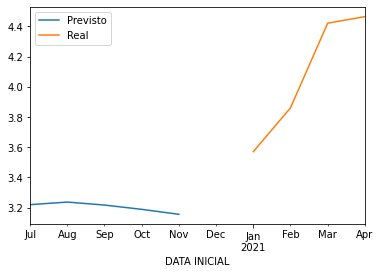

In [210]:
prediction.plot(label='Previsto')
data_pern_test['PREÇO MÉDIO REVENDA'].plot(label='Real')
plt.legend()

In [211]:
hwes_mse = ((data_pern_test['PREÇO MÉDIO REVENDA'] - prediction) ** 2).mean()
hwes_mse

nan

In [212]:
mlflow.log_metric('hwes_mse', hwes_mse)

In [213]:
print(
    f'MSE SARIMAX: {sarimax_mse}\n'
    f'MSE Prophet: {prophet_mse}\n'
    f'MSE AutoRegression: {ar_mse}\n'
    f"MSE Holt Winter's Exponential Smoothing: {hwes_mse}\n"
)

MSE SARIMAX: 0.6915642562430931
MSE Prophet: 0.4622559604531198
MSE AutoRegression: nan
MSE Holt Winter's Exponential Smoothing: nan



O algoritmo Prophet apresentou o menor MSE, de forma que tentaremos melhorar sua performance em seguida. A ferramenta disponibilizada pelo Prophet para diagnósticos é uma função de validação cruzada periódica sobre um dataframe de treinamento, que deve se seguir de um Grid-Search para escolha de hiperparâmetros. Acontece que o Optuna já disponibiliza essa funcionalidade, portanto, rodaremos sua otimização novamente, com quantidade de tentativas consideravelmente maior.

In [214]:
prophet_final_study = optuna.create_study(direction="minimize")
prophet_final_study.optimize(prophet_objective, n_trials=300)

[I 2022-09-15 19:25:03,420] A new study created in memory with name: no-name-1fe0ee23-18b1-4aab-bbe9-ed1e024cbb48
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp903hhn6f/ak696pt4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp903hhn6f/f7e8wc2r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6554', 'data', 'file=/tmp/tmp903hhn6f/ak696pt4.json', 'init=/tmp/tmp903hhn6f/f7e8wc2r.json', 'output', 'file=/tmp/tmpbnn048dp/prophet_model-20220915192503.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:25:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:25:03 - cmdstanpy - INFO - Chain [1] done pr

In [215]:
print_study_best_trial_params(prophet_final_study)

Melhor valor: 0.015485571166728168
Melhores parâmetros:
changepoint_prior_scale: 0.3116433774893741
seasonality_prior_scale: 0.010182638071118303
holidays_prior_scale: 1.2133454941244


In [216]:
for param, val in prophet_final_study.best_trial.params.items():
    mlflow.log_param(f'final_prophet_{param}', val)

In [217]:
final_prophet = Prophet(**prophet_final_study.best_trial.params)
final_prophet.fit(prophet_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp903hhn6f/54d7mlsr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp903hhn6f/ct0_jgbq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=46824', 'data', 'file=/tmp/tmp903hhn6f/54d7mlsr.json', 'init=/tmp/tmp903hhn6f/ct0_jgbq.json', 'output', 'file=/tmp/tmp2k9j4sll/prophet_model-20220915193708.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:37:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:37:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [218]:
mlflow.sklearn.log_model(final_prophet, 'final_prophet')

ModelInfo(artifact_path='final_prophet', flavors={'python_function': {'model_path': 'model.pkl', 'loader_module': 'mlflow.sklearn', 'python_version': '3.7.14', 'env': 'conda.yaml'}, 'sklearn': {'pickled_model': 'model.pkl', 'sklearn_version': '1.0.2', 'serialization_format': 'cloudpickle', 'code': None}}, model_uri='runs:/ca633405d54e482cbc7d23084592682a/final_prophet', model_uuid='1aa62097d2eb46c9882697c2d93c1241', run_id='ca633405d54e482cbc7d23084592682a', saved_input_example_info=None, signature_dict=None, utc_time_created='2022-09-15 19:37:08.863126', mlflow_version='1.28.0')

In [219]:
future_df = final_prophet.make_future_dataframe(periods=6, freq='m')
future_pred = final_prophet.predict(future_df)

In [222]:
last_6_months = future_pred['yhat'][-4:].reset_index(drop=True)
last_6_months.index = data_pern_test.index

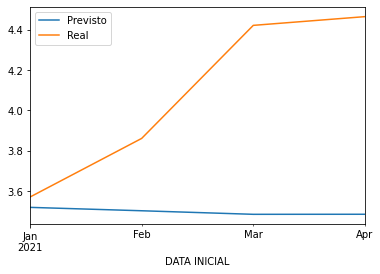

In [224]:
last_6_months.plot(label='Previsto')
data_pern_test['PREÇO MÉDIO REVENDA'].plot(label='Real')
plt.legend()

In [225]:
mse_final_prophet = ((data_pern_test['PREÇO MÉDIO REVENDA'] - last_6_months) ** 2).mean()
mse_final_prophet

0.4927467859640705

Finalmente, comparemos o novo MSE com o prévio

In [226]:
print(
    f'MSE Prophet Original: {prophet_mse}\n'
    f'MSE Prophet Final: {mse_final_prophet}'
)

MSE Prophet Original: 0.4622559604531198
MSE Prophet Final: 0.4927467859640705


Não foi possível obter melhora